In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import analyze # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime
import pickle
from scipy.stats import norm
import shutil

%matplotlib inline

# Job Submission

In [ ]:
from make_runlist_new import write_spe_lists

#dry run
write_spe_lists(write=False)

In [ ]:
#writes new runlists
written=write_spe_lists(write=True)
print(written)

### This will take some time to run as job submission takes several hours. Alternatively, in the terminal you can run ./submit_jobs.sh ./runlists/[runlist name] for a single runlist, or ./large_submission.sh to submit jobs for all runlists in ./runlists

In [ ]:
def submit_job(file):
    command = "./submit_jobs.sh %s" % file
    print(command)
    !{command}

In [ ]:
for f in written:
    submit_job(f)

# Acc Vs Time

### Calculating acceptance and error data

In [2]:
import hax
#hax already initiated when analyze is imported

from spe_acceptance import data_dir_base, rawdata_dir


def data_exists(run_number):
    data_path=os.path.join(data_dir_base, 'run_%05d.h5' %int(run_number))
    return os.path.exists(data_path)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]
    
def find_file(run):
    return [f for f in os.listdir('runlists') if any(int(run)==elem for elem in file_to_list(f))]

#### Retrieves previously loaded data from pickle file

In [3]:
#all runlists
runlists = [f for f in os.listdir('./runlists')]
bottom_runs = []
accs = []

ch_acc_dict={}
ch_err_l={}
ch_err_u={}

occ_dict={}

upper_errs=[]
lower_errs=[]
errors = []

on_ch_dict={}

missing_runs = []
LED_off = []
resubmit_files = []

with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl', 'rb') as cd:
    if os.stat('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl').st_size==0:
        print('No data in pickle file')
        data=[]
    else:
        data=pickle.load(cd)
saved_runlists=[]


for cd in data:
    if len(data)==0:
        continue
        
    runlist = file_to_list(cd.runlist)
    if not all_data_exists(runlist):
        resubmit_files.append(cd.runlist)
        for r in runs:
            if not data_exists(r):
                missing_runs.append(r)
        continue    
          
    saved_runlists.append(cd.runlist)
    
    
    acc=cd.acc
    acc_errs_l=cd.acc_errs_l
    acc_errs_u=cd.acc_errs_u
    acc_sys=cd.acc_sys
    acc_stat=cd.acc_stat
    occ=cd.occ
    occ_sys=cd.occ_sys
    occ_stat=cd.occ_stat
    on_channels = cd.on_channels
    
    on_ch_dict[cd.runlist]=on_channels
      
    
    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]
    
    if len(on_channels) < 200:
        LED_off.append(cd.runlist)
    
    else:
        ch_acc_dict[cd.runlist]=acc
        occ_dict[cd.runlist]=occ
    
        on_acc=acc[on_channels]

        #make error dicts
        ch_err_l[cd.runlist]=acc_errs_l
        ch_err_u[cd.runlist]=acc_errs_u

        bottom_runs.append(bottom_run)
        accs.append(np.mean(on_acc))
        #avg err=sqrt(sum(channel errors**2)/# of channels)
        lower_errs.append(np.sqrt(np.sum(acc_errs_l[on_channels]**2)/len(on_channels)))
        upper_errs.append(np.sqrt(np.sum(acc_errs_u[on_channels]**2)/len(on_channels)))

print("Data already exists for: ", saved_runlists)

Data already exists for:  ['runlist_9549_9550_9551.txt', 'runlist_9549_9550_9551.txt', 'runlist_12587_12588_12589.txt', 'runlist_7350_7351_7352.txt', 'runlist_6909_6910_6911.txt', 'runlist_6550_6551_6552.txt', 'runlist_7067_7068_7069.txt', 'runlist_12768_12769_12770.txt', 'runlist_11429_11430_11431.txt', 'runlist_7447_7448_7449.txt', 'runlist_16984_16985_16986.txt', 'runlist_10696_10697_10698.txt', 'runlist_6957_6958_6959.txt', 'runlist_12046_12047_12048.txt', 'runlist_17454_17455_17456.txt', 'runlist_7968_7969_7970.txt', 'runlist_7646_7647_7648.txt', 'runlist_11625_11626_11627.txt', 'runlist_17998_17999_18000.txt', 'runlist_10133_10134_10135.txt', 'runlist_8448_8449_8450.txt', 'runlist_7758_7759_7760.txt', 'runlist_6938_6939_6940.txt', 'runlist_16343_16344_16345.txt', 'runlist_9604_9605_9606.txt', 'runlist_9033_9034_9036.txt', 'runlist_7485_7486_7487.txt', 'runlist_11069_11070_11071.txt', 'runlist_7569_7570_7571.txt', 'runlist_16701_16702_16703.txt', 'runlist_8921_8922_8923.txt', 'run

In [ ]:
#just newest runlist

#newest_runlist= find_file(sorted(bottom_runs)[-1])[0]
#print("Newest Runlist: ", newest_runlist)
#runlist = file_to_list(newest_runlist)

#if str(newest_runlist) not in saved_runlists:
rl=['./runlists/runlist_18928_18929_18930.txt', './runlists/runlist_18846_18847_18848.txt', './runlists/runlist_18562_18563_18564.txt', './runlists/runlist_18383_18384_18385.txt']
for runlist in tqdm(runlists):
    runs=file_to_list(runlist)
    if not all_data_exists(runs):
        resubmit_files.append(runlist)
        for r in runs:
            if not data_exists(r):
                missing_runs.append(r)
        continue


    bottom_run = runs[0]
    topbulk_run = runs[1]
    topring_run = runs[2]

    thresholds = analyze.get_thresholds(analyze.find_regular_run(bottom_run))

    acc, acc_stat, acc_sys = analyze.acceptance_3runs(bottom_run, topbulk_run, topring_run, thresholds, val2corr2=6, space='amplitude')
    occ, occ_sys, occ_stat = analyze.occupancy_3runs(bottom_run, topbulk_run, topring_run, val2corr2=6, space='amplitude')

    on_channels = np.where(occ > 0.05)[0]
    
    on_ch_dict[runlist]=on_channels

    if len(on_channels) < 200:
        LED_off.append(runlist)
    
    else:
        on_acc = acc[on_channels]
        on_occ = occ[on_channels]

        ch_acc_dict[runlist]=acc
        occ_dict[runlist]=occ


        acc_errs_l = np.sqrt(acc_stat[0]**2+acc_sys**2)
        acc_errs_u = np.sqrt(acc_stat[1]**2+acc_sys**2)

        ch_err_l[runlist]=acc_errs_l
        ch_err_u[runlist]=acc_errs_u

        accs.append(np.mean(on_acc))
        lower_errs.append(np.sqrt(np.sum(acc_errs_l[on_channels]**2)/len(on_channels)))
        upper_errs.append(np.sqrt(np.sum(acc_errs_u[on_channels]**2)/len(on_channels)))
        bottom_runs.append(bottom_run)

        cd=analyze.ch_data(runlist, get_run_time(bottom_run), acc, acc_errs_l, acc_errs_u, acc_sys, acc_stat, occ, occ_sys, occ_stat, on_channels)
        data.append(cd)

errors=np.array([lower_errs, upper_errs])

#### Calculates acceptance, errors for new runlist

In [4]:
#just newest runlist

newest_runlist= find_file(sorted(bottom_runs)[-1])[0]
print("Newest Runlist: ", newest_runlist)
runlist = file_to_list(newest_runlist)

if str(newest_runlist) not in saved_runlists:
    if not all_data_exists(runlist):
        resubmit_files.append(newest_runlist)
        for r in runlist:
            if not data_exists(r):
                missing_runs.append(r)
            continue


    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]

    thresholds = analyze.get_thresholds(analyze.find_regular_run(bottom_run))

    acc, acc_stat, acc_sys = analyze.acceptance_3runs(bottom_run, topbulk_run, topring_run, thresholds)
    occ, occ_sys, occ_stat = analyze.occupancy_3runs(bottom_run, topbulk_run, topring_run)

    on_channels = np.where(occ > 0.05)[0]
    
    on_ch_dict[newest_runlist]=on_channels

    if len(on_channels) < 200:
        LED_off.append(newest_runlist)
        print("LED likely off for %s" %newest_runlist)
        
    else:
        on_acc = acc[on_channels]
        on_occ = occ[on_channels]

        ch_acc_dict[newest_runlist]=acc
        occ_dict[newest_runlist]=occ

        acc_errs_l = np.sqrt(acc_stat[0]**2+acc_sys**2)
        acc_errs_u = np.sqrt(acc_stat[1]**2+acc_sys**2)

        ch_err_l[newest_runlist]=acc_errs_l
        ch_err_u[newest_runlist]=acc_errs_u

        accs.append(np.mean(on_acc))
        lower_errs.append(np.sqrt(np.sum(acc_errs_l[on_channels]**2)/len(on_channels)))
        upper_errs.append(np.sqrt(np.sum(acc_errs_u[on_channels]**2)/len(on_channels)))
        bottom_runs.append(bottom_run)

        cd=analyze.ch_data(newest_runlist, get_run_time(bottom_run), acc, acc_errs_l, acc_errs_u, acc_sys, acc_stat, occ, occ_sys, occ_stat, on_channels)
        data.append(cd)

else:
    print("Data already in pickle file")

errors=np.array([lower_errs, upper_errs])

Newest Runlist:  runlist_18928_18929_18930.txt
Data already in pickle file


#### Dumps all data into pickle file, prints runs with LED off and runs with missing data, deletes raw data for processed runs

In [ ]:
run=18287
s=analyze.SPE(os.path.join(data_dir_base, 'run_%d.h5' %run))

ch=125
res, sig_res, led, noise=s.residual(6, 'amplitude')
residual, bins=np.histogram(res, bins=1099, range=(-100.5, 999.5))
bins = 0.5 * (bins[1:] + bins[:-1])
plt.figure()
#plt.plot(bins, res[])
plt.xlim(-50,300)
plt.yscale('log')
plt.errorbar(bins, res[ch], yerr=sig_res[ch], marker='.', linestyle='None')
plt.xlabel("Amplitude[ADC Counts]")
plt.title("Residual for Ch %d" %ch)
plt.ylabel("Counts/Bin")
plt.show()

In [ ]:
acc_curves=analyze.acc_MC(res[ch], sig_res[ch], 1000)

plt.figure(figsize=(9,6))
plt.plot(bins, acc_curves.T, color='k', alpha=0.05)
plt.xlabel('Amplitude[ADC Counts]')
plt.ylabel("Acc Frac")
plt.title('MC Curves for run %d, ch %d' %(run, ch))
plt.xlim(-10,50)
plt.ylim(0.7, 1)
plt.grid()
plt.show()

In [ ]:
LED, led_bins=np.histogram(led.T, bins=1099, range=(-100.5, 999.5))
NOISE, noise_bins=np.histogram(noise.T, bins=1099, range=(-100.5, 999.5))
led_bins = 0.5 * (led_bins[1:] + led_bins[:-1])
noise_bins = 0.5 * (noise_bins[1:] + noise_bins[:-1])
sigma_led=np.sqrt(np.array(LED))
sigma_noise=np.sqrt(np.array(NOISE))
plt.figure()
plt.errorbar(led_bins, led.T[ch], yerr=sigma_led, linewidth=3)
plt.errorbar(noise_bins, noise.T[ch], yerr=sigma_noise)
plt.xlabel('Amplitude [ADC Counts]')
plt.ylabel("Counts/Bin")
plt.title("Noise/LED, ch %d" %ch)
plt.xlim(-20,20)
plt.yscale('log')
plt.show()

In [ ]:
r_acc=analyze.A_func(res)

plt.figure()
plt.plot(bins, r_acc[ch])
plt.xlabel('Amplitude[ADC Counts]')
plt.ylabel("Acc Frac")
plt.title("Acc Curve for Ch %d, run %d" %(ch, run))
plt.xlim(-50,300)
plt.show()


In [ ]:
amp_vals=[i for i in range(3,20)]
q_vals=[i for i in range(-60,60)]

amp_occ_dict={}
q_occ_dict={}

amp_occ_array=np.ones((len(amp_vals)))
q_occ_array=np.ones((len(q_vals)))

ratio_df=pd.DataFrame(0, index=q_vals, columns=amp_vals)

for a,a_val in enumerate(amp_vals):
    for q, q_val in enumerate(q_vals):
        q_corrs, q_errs=s.make_correction(q_val, 'charge')
        amp_corrs, amp_errs=s.make_correction(a_val, 'amplitude')
        
        q_corr=q_corrs[ch]
        amp_corr=amp_corrs[ch]
        
        #print(-np.log(q_corr), -np.log(amp_corr))
        
        amp_occ_dict[a_val]=-1*np.log(amp_corrs)
        q_occ_dict[q_val]=-1*np.log(q_corrs)
        
        amp_occ_array[a]=-1*np.log(amp_corr)
        q_occ_array[q]=-1*np.log(q_corr)
        
        #print(q_occ)
        
        ratio_df.loc[q_val,a_val]=q_occ_array[q]/amp_occ_array[a]

ratio_df

In [ ]:
amp_df=pd.DataFrame(amp_occ_dict)
q_df=pd.DataFrame(q_occ_dict)
amp_df

In [ ]:
def ratio(x,y):
    ratio_array=np.ones((len(q_vals), len(amp_vals)))
    for a in tqdm(x):
        for b, a2 in enumerate(a):
            for c, y2 in enumerate(y):
                ratio_array[c,b]=q_df.iloc[ch, c]/amp_df.iloc[ch,b]
    return ratio_array

In [ ]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [ ]:
X, Y=np.meshgrid(amp_vals, q_vals)
#Z=ratio(X,Y) #takes a while

cl=plt.contour(X,Y, ratio_df.values, levels=[1])#, norm=MidpointNormalize(midpoint=1))
plt.clabel(cl, fmt = '%2.1d', fontsize=14)
cp=plt.contourf(X,Y,ratio_df.values, levels=np.linspace(0,2,1000), cmap='seismic', vmin=0, vmax=2)
plt.colorbar(cp,label='$\lambda_q/\lambda_{amp}$') 
plt.xlabel("Amp Bin Choice")
plt.ylabel("Charge Bin Choice")
plt.title('Charge_Occ/Amp_Occ for Run %d, ch %d' %(run, ch))
plt.show()

In [ ]:
occ_df=pd.DataFrame(occ_dict)

ch=126

ch_occs=occ_df.loc[ch,:]

occ_dates = []
for runlist in occ_df.columns:
    runs=file_to_list(runlist)
    occ_dates.append(get_run_time(runs[0]))

outlier_occs=np.where(ch_occs<0.1)
#print(outlier_occs)
#print(*occ_df.loc[:, 'runlist_11069_11070_11071.txt'])
#print(occ_df.columns[list(outlier_occs)])


In [ ]:
occ_runlist=find_file(run)[0]#'runlist_17249_17250_17251.txt'#'runlist_11069_11070_11071.txt'
#runs=file_to_list(occ_runlist)

#with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/q_occ.pkl', 'wb') as q:
#    charge_occ_dict=pickle.load(q)

charge_occ_dict={}
for bot_run in tqdm(bottom_runs):
    runs=file_to_list(find_file(bot_run)[0])
    q_occs, q_sys, q_stat=analyze.occupancy_3runs(runs[0], runs[1], runs[2])
    charge_occ_dict[find_file(bot_run)[0]]=q_occs

#os.remove('/project/lgrandi/xenon1t/spe_acceptance/ch_data/q_occ.pkl')
#with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/q_occ.pkl', 'wb') as q:
#    pickle.dump(charge_occ_dict, q)
    
charge_df=pd.DataFrame(charge_occ_dict)
charge_df

charge_occs=charge_df.loc[ch,:]

In [ ]:
print(run)
plt.figure()
plt.plot(on_ch_dict[occ_runlist], occ_df.loc[on_ch_dict[occ_runlist],occ_runlist ], linestyle='None', marker='.', label="Amp")
#plt.plot(on_ch_dict[occ_runlist], charge_df.loc[on_ch_dict[occ_runlist], occ_runlist], linestyle='None', marker='.', label="Charge")
plt.xlabel('Channel #')
plt.ylabel("Occupancy")
plt.title("All ch occ for run %d" %run)
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(occ_dates, ch_occs, linestyle='None', marker='.', label='Amp')
plt.plot(occ_dates, charge_occs, linestyle='None', marker='.', label="Charge")
plt.title("Occs for channel %d, all runlists" %ch)
plt.xlabel("Run Date")
plt.ylabel("Occupancy")
plt.legend()
plt.show()

In [ ]:
occ_runlist=newest_runlist#'runlist_17249_17250_17251.txt'#'runlist_11069_11070_11071.txt'
plt.figure()
plt.plot(on_ch_dict[occ_runlist], q_df.loc[on_ch_dict[occ_runlist], -25], linestyle='None', marker='.')
plt.xlabel('Channel #')
plt.ylabel("Occupancy")
plt.title("All ch occ for %s" %occ_runlist)
plt.show()

In [ ]:
from spe_acceptance import change_permissions

os.remove('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl')
with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl', 'wb') as cd:
    pickle.dump(data, cd)
change_permissions('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl')

In [42]:
#Delete raw data after processed data is in the pickle file
from get_name import get_name
no_data=[]
for runlist in runlists:
    with open(os.path.join('./runlists', runlist)) as r:
        for run in r.readlines():
            name=get_name(int(run))
            raw_path=os.path.join(rawdata_dir, name)
            pro_path=os.path.join(data_dir_base, 'run_%d.h5' % int(run))
            if not os.path.exists(raw_path):
                no_data.append(run)
                continue
            if os.path.exists(raw_path):
                if os.path.exists(pro_path):
                    shutil.rmtree(raw_path)
                    print("Deleting raw data for: ", run, name)
    
print("These runs are missing data: ", missing_runs)
print("LED likely off for these files: ", LED_off)

Deleting raw data for:  18563
 180420_0911
Deleting raw data for:  18564
 180420_0921
Deleting raw data for:  17998
 180331_1359
Deleting raw data for:  17999
 180331_1412
Deleting raw data for:  18000
 180331_1423
Deleting raw data for:  18385
 180413_0841
Deleting raw data for:  18286
 180409_1617
Deleting raw data for:  18287
 180409_1626
Deleting raw data for:  18288
 180409_1638
Deleting raw data for:  18191
 180406_1113
Deleting raw data for:  18192
 180406_1203
These runs are missing data:  []
LED likely off for these files:  []


#### Resubmits jobs for runs missing data

In [ ]:
for f in resubmit_files:
    runs=file_to_list(f)
    submit=os.path.join('./runlists', f)
    if runs[0]<6731:
        continue
    submit_job(submit)

#### Acceptance dataframe with channels as row index, runlists as column index

In [5]:
acc_df=pd.DataFrame(ch_acc_dict)
channels_df=pd.DataFrame({"channels": [i for i in range(0,248)]})
ch_df=pd.concat([acc_df, channels_df], axis=1)
ch_df.set_index('channels', inplace=True)
ch_df.iloc[:, -1]

channels
0      1.000259
1      0.003885
2     -0.000963
3      0.956567
4      0.913430
5      0.615053
6      1.050251
7      0.933586
8      1.003515
9      1.005445
10     0.978832
11     0.997595
12     0.000000
13     0.998674
14     0.945902
15     0.923932
16     1.021196
17     0.917091
18     0.971543
19     0.958229
20     0.907815
21     0.843365
22     0.965517
23     0.927486
24     0.946522
25     0.870534
26     0.000000
27     0.386485
28     0.939080
29     0.904195
         ...   
218    0.809828
219    0.960421
220    0.979735
221    0.981865
222    1.010598
223    1.057709
224    1.022336
225    0.917058
226    0.971161
227    0.909529
228    0.960111
229    0.971373
230    1.110956
231    1.014277
232    0.954647
233    0.894415
234    0.000000
235    0.966201
236    0.810969
237    0.848565
238    1.017908
239    0.000000
240    0.991250
241    0.984655
242    1.102722
243    0.880693
244    0.000005
245    0.979508
246    0.925458
247    1.061223
Name: runlist_9

#### Lower, upper errors dataframes with channels as row index, runlist as column index

In [6]:
lerr_df=pd.DataFrame(ch_err_l)
ch_lerr_df=pd.concat([lerr_df, channels_df], axis=1)
ch_lerr_df.set_index('channels', inplace=True)
ch_lerr_df

,runlist_10064_10065_10066.txt,runlist_10133_10134_10135.txt,runlist_10297_10298_10299.txt,runlist_10524_10525_10526.txt,runlist_10610_10611_10612.txt,runlist_10696_10697_10698.txt,runlist_10796_10797_10798.txt,runlist_10877_10878_10879.txt,runlist_10986_10987_10988.txt,runlist_11069_11070_11071.txt,...,runlist_8840_8841_8842.txt,runlist_8921_8922_8923.txt,runlist_9033_9034_9036.txt,runlist_9112_9113_9114.txt,runlist_9217_9218_9219.txt,runlist_9299_9300_9301.txt,runlist_9549_9550_9551.txt,runlist_9604_9605_9606.txt,runlist_9697_9698_9699.txt,runlist_9797_9798_9799.txt
channels,,,,,,,,,,,,,,,,,,,,,
0,0.026218,0.030496,0.016727,0.030385,0.027149,0.017558,0.021452,0.024693,0.033287,0.029304,...,0.019854,0.024334,0.024266,0.019528,0.029238,0.026300,0.019660,0.034267,0.031239,0.021132
1,0.006574,0.007138,0.000000,0.002566,0.001314,0.061715,0.010825,0.030230,0.008347,0.002750,...,0.004749,0.024459,0.208352,0.005261,0.007539,0.025022,0.028549,0.249826,0.036552,0.001937
2,0.003471,0.001193,0.007669,0.004546,0.085782,0.003601,0.002868,0.001229,0.000551,0.001113,...,0.000000,0.003234,0.000720,0.000000,0.004018,0.000725,0.044626,0.000389,0.001027,0.006515
3,0.050762,0.039231,0.061954,0.040628,0.047423,0.038217,0.025206,0.043786,0.074840,0.015686,...,0.030016,0.035041,0.029382,0.028081,0.022355,0.031876,0.022320,0.035487,0.031969,0.013813
4,0.025454,0.030284,0.033193,0.029395,0.033853,0.038200,0.040603,0.028464,0.021098,0.054863,...,0.028545,0.017879,0.016673,0.022315,0.028910,0.015856,0.018961,0.022589,0.028058,0.052561
5,0.044753,0.045437,0.047755,0.034393,0.023937,0.031398,0.041946,0.023430,0.019827,0.042649,...,0.027726,0.016744,0.033402,0.027778,0.049261,0.040203,0.019664,0.083303,0.049868,0.099574
6,0.036049,0.028650,0.021057,0.022396,0.020280,0.030651,0.040194,0.030424,0.014529,0.114073,...,0.032371,0.021117,0.020882,0.015528,0.035914,0.038752,0.018149,0.020621,0.030932,0.037948
7,0.038484,0.028996,0.042567,0.032819,0.037527,0.035139,0.030047,0.038768,0.029099,0.032495,...,0.021326,0.020275,0.023448,0.030744,0.032778,0.015314,0.017552,0.032075,0.026792,0.028796
8,0.029785,0.024105,0.024394,0.025220,0.019586,0.016194,0.020637,0.031573,0.024377,0.105906,...,0.022717,0.022491,0.023305,0.016223,0.024374,0.023821,0.024443,0.020452,0.028668,0.022890


In [7]:
uerr_df=pd.DataFrame(ch_err_u)
ch_uerr_df=pd.concat([uerr_df, channels_df], axis=1)
ch_uerr_df.set_index('channels', inplace=True)
ch_uerr_df.loc[246, :]

runlist_10064_10065_10066.txt    0.094702
runlist_10133_10134_10135.txt    0.111150
runlist_10297_10298_10299.txt    0.102912
runlist_10524_10525_10526.txt    0.091248
runlist_10610_10611_10612.txt    0.110800
runlist_10696_10697_10698.txt    0.068858
runlist_10796_10797_10798.txt    0.086203
runlist_10877_10878_10879.txt    0.084112
runlist_10986_10987_10988.txt    0.072813
runlist_11069_11070_11071.txt    0.101926
runlist_11352_11353_11354.txt    0.101812
runlist_11429_11430_11431.txt    0.069776
runlist_11535_11536_11537.txt    0.082080
runlist_11625_11626_11627.txt    0.090964
runlist_11733_11734_11736.txt    0.090597
runlist_11813_11814_11815.txt    0.083955
runlist_12046_12047_12048.txt    0.092439
runlist_12130_12131_12132.txt    0.102907
runlist_12211_12213_12214.txt    0.094409
runlist_12318_12319_12320.txt    0.059748
runlist_12398_12399_12400.txt    0.098398
runlist_12511_12512_12513.txt    0.089257
runlist_12587_12588_12589.txt    0.084323
runlist_12768_12769_12770.txt    0

In [22]:
rl=['runlist_18928_18929_18930.txt', 'runlist_18846_18847_18848.txt', 
    'runlist_18562_18563_18564.txt', 'runlist_18383_18384_18385.txt']

with open('/project/lgrandi/xenon1t/spe_acceptance/data/new_runs.txt', 'w') as nr:
    for runlist in rl:
        on_ch=on_ch_dict[runlist]
        nr.write(runlist)
        nr.write("Mean Acc:") 
        nr.write(str(np.mean(ch_df.loc[on_ch, runlist])))
        nr.write("Acc by Ch:")
        for i in ch_df.loc[on_ch, runlist]:
            nr.writelines("%s\n" %str(i))
        nr.write("Mean Error [lower, upper]:")
        nr.write(str(np.sqrt(np.sum(ch_lerr_df.loc[on_ch, runlist]**2))/len(on_ch)))
        nr.write(str(np.sqrt(np.sum(ch_uerr_df.loc[on_ch,runlist]**2))/len(on_ch)))
        nr.write("Lower Error by Ch:")
        for i in ch_lerr_df.loc[on_ch, runlist]:
            nr.writelines("%s\n" %str(i))
        nr.write("Upper Error by Ch:") 
        for i in ch_uerr_df.loc[on_ch, runlist]:
            nr.writelines("%s\n" %str(i))
    nr.close()

runlist_18928_18929_18930.txt
[  0   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  63  64  66  67  68  69  70  71  72  73  74  75  76
  77  78  80  81  82  83  84  85  86  89  90  92  93  94  95  96  97  98
  99 100 101 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 119 120 121 122 123 124 125 126 127 128 129 131 132 133 136 138 140 141
 142 143 144 145 146 147 148 149 151 153 154 155 156 157 158 159 160 161
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 179 180 181
 182 184 185 186 187 188 189 190 191 192 193 194 195 196 197 199 200 201
 202 204 205 207 208 209 210 211 212 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 235 236 237 238 240 241 242 243
 245 246 247]
runlist_18846_18847_18848.txt
[  0   3   4   5   6   7   8   9  10  11  12  13  

KeyError: 'runlist_18562_18563_18564.txt'

## Newest Runlist

#### Finds newest runlist, gets acceptance and occupancy 

#### Channels that look off, note that this includes both channels that are actually off and channels that aren't performing properly

In [24]:
#prints list of off pmts
new_on_ch=on_ch_dict[newest_runlist]
my_off = np.where(occ_dict[newest_runlist][new_on_ch] < 0.05)[0]
print("Channels that look off for %s: " %newest_runlist , my_off)

Channels that look off for runlist_18928_18929_18930.txt:  []


#### Acceptance histogram for one runlist

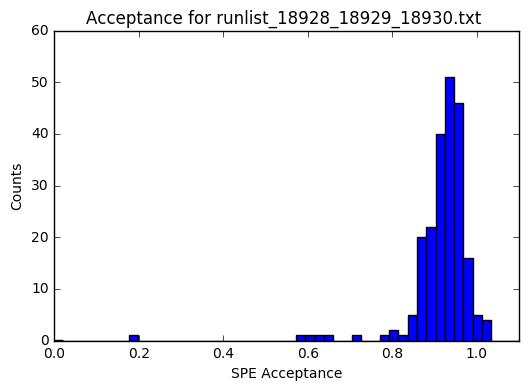

In [25]:
#plot the acceptance of one runlist

plt.hist(ch_df.loc[new_on_ch,newest_runlist], bins=50, range=(0,1.1))
plt.title("Acceptance for %s " %newest_runlist)
plt.xlabel("SPE Acceptance")
plt.ylabel("Counts")
plt.xlim(0, 1.1)
plt.show()

#### Occupancy histogram for one runlist

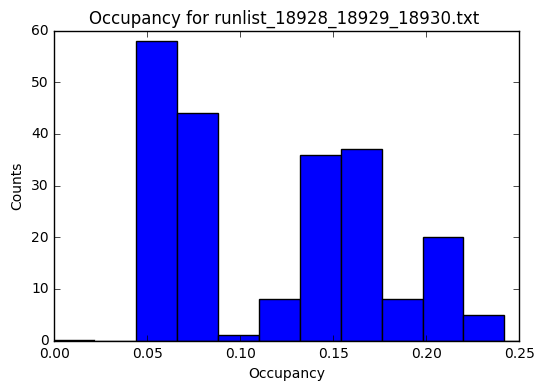

In [26]:
#plot the occupancy of one runlist
plt.hist(occ_dict[newest_runlist][on_ch_dict[newest_runlist]], bins=50, range=(0,1.1))
plt.title("Occupancy for %s " %newest_runlist)
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.xlim(0,0.25)
plt.show()

#### Acceptance of all channels for the newest runlist

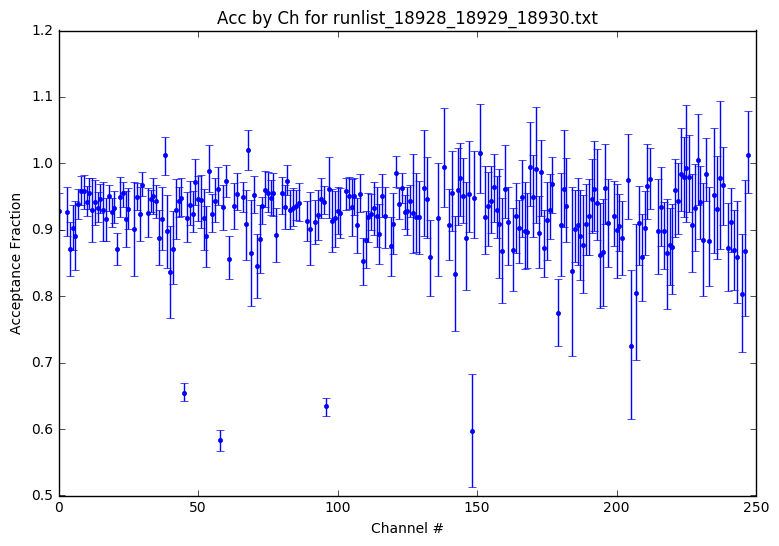

In [27]:
#plot acceptance of each channel

plt.figure(figsize=(9,6))
plt.errorbar(new_on_ch, ch_df.loc[new_on_ch,newest_runlist], yerr=[ch_lerr_df.loc[new_on_ch, newest_runlist], ch_uerr_df.loc[new_on_ch,newest_runlist]], marker='.', linestyle='none')
plt.ylabel('Acceptance Fraction')
plt.xlabel('Channel #')
plt.ylim(0.5,1.2)
plt.title('Acc by Ch for %s' %newest_runlist)
plt.show()

#### Prints low acceptance channels

In [28]:
#prints list of low acc ch
cha_dict_new={}

for ch, a in zip(new_on_ch, ch_df.loc[new_on_ch, newest_runlist]):
    cha_dict_new[a]=ch
    
new_low_acc_ch=[]
for a in ch_df.loc[new_on_ch, newest_runlist]:
    if a<0.5:
        new_low_acc_ch.append(cha_dict_new[a])
        
print('Low acc ch for %s: ' %newest_runlist, new_low_acc_ch)

Low acc ch for runlist_18928_18929_18930.txt:  [31]


#### Mean, Median, Errors for runlist

In [29]:
#maybe including off channels in mean
acc_mean=np.nanmean(ch_df.loc[new_on_ch, newest_runlist])
acc_median=np.nanmedian(ch_df.loc[new_on_ch, newest_runlist])
lower_error=np.sqrt(np.nansum(ch_lerr_df.loc[new_on_ch, newest_runlist]**2)/len(new_on_ch))
upper_error=np.sqrt(np.nansum(ch_uerr_df.loc[new_on_ch, newest_runlist]**2)/len(new_on_ch))

print("Runlist: ", newest_runlist)
print("Mean Acceptance: ", acc_mean)
print("Median Acceptance: ", acc_median)
print("Errors [l,u]: ", [lower_error, upper_error])

Runlist:  runlist_18928_18929_18930.txt
Mean Acceptance:  0.916337703633
Median Acceptance:  0.929280655758
Errors [l,u]:  [0.051624346683067403, 0.055027301593784522]


## Average Acceptance per Runlist

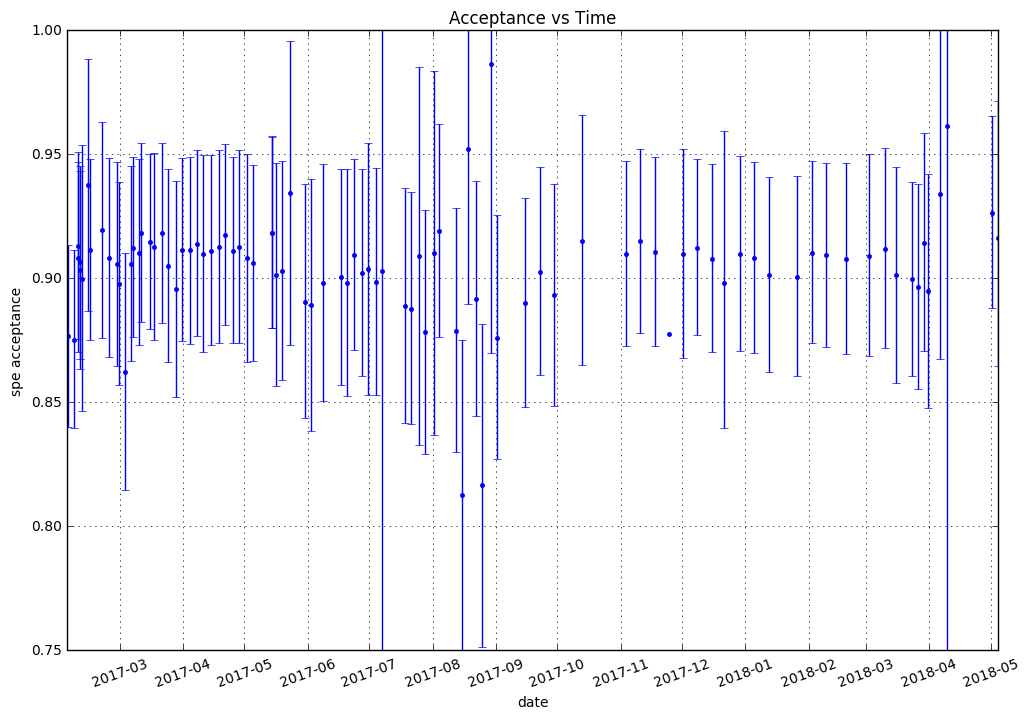

In [31]:
#plot acceptance vs time using full runlists

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%Y-%m')

bottom_runs = np.array(bottom_runs)
dates = np.array([get_run_time(run) for run in bottom_runs])
accs = np.array(accs)

noisy_runs = [12768, 13837]
sr1 = np.where(bottom_runs > 6731)
sr1 = [i for i in sr1[0] if bottom_runs[i] not in noisy_runs]
plot_dates = dates[sr1]
plot_runs = bottom_runs[sr1]
plot_accs = accs[sr1]
plot_errors = [errors[0][sr1],errors[1][sr1]]

f, ax = plt.subplots(figsize=(12,8))
ax.errorbar(plot_dates, plot_accs, yerr=plot_errors, linestyle='None', marker='.')
ax.set_ylim(0.75, 1.0)
plt.xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
ax.grid()
ax.set_xlabel('date')
ax.set_ylabel('spe acceptance')
plt.title("Acceptance vs Time")
plt.savefig('new_moneyplot.png')
plt.show()

#### Mean, Median, Errors for all runlists

In [32]:
#add table of mean/median w errors for time evo, print days that are outliers

evo_mean=np.nanmean(plot_accs)
evo_median=np.nanmedian(plot_accs)
evo_errs=[np.nanmean(plot_errors[0]), np.nanmean(plot_errors[1])]

evo_std=np.nanstd(plot_accs)

print("All Runlists")
print("Mean :", evo_mean)
print("Median :", evo_median)
print("Errors [l, u]: ", evo_errs)

All Runlists
Mean : 0.905213445691
Median : 0.908246123413
Errors [l, u]:  [0.048890768390642186, 0.049297838509597798]


## Acceptance for Individual Channels

### One Channel

#### Plots acceptances of one channel for all runlists

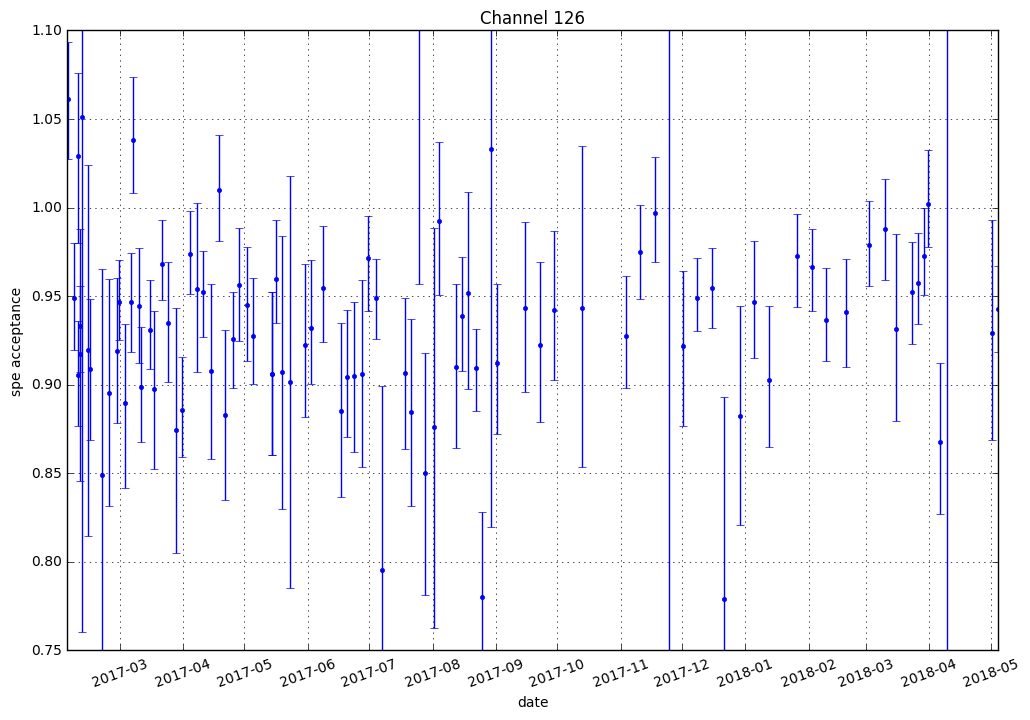

In [33]:
ch=126

#list of lists of runlists
sr1_rl=[find_file(i) for i in bottom_runs[sr1]]

#list of runlists
sr1_rl=[runlist for elem in sr1_rl for runlist in elem]

plt.figure(figsize=(12,8))
plt.errorbar(plot_dates, ch_df.loc[ch, sr1_rl] , yerr=[ch_lerr_df.loc[ch, sr1_rl], ch_uerr_df.loc[ch, sr1_rl]], linestyle='None', marker='.')
plt.ylim(0.75, 1.1)
plt.xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
plt.grid()
plt.title("Channel %s" %ch)
plt.xlabel('date')
plt.ylabel('spe acceptance')
plt.show()

In [34]:
#add table of mean/median w errors for time evo, print days that are outliers

ch_mean=np.nanmean(ch_df.loc[ch, sr1_rl])
ch_median=np.nanmedian(ch_df.loc[ch,sr1_rl])
ch_errs=[np.nanmean(ch_lerr_df.loc[ch, sr1_rl]), np.nanmean(ch_uerr_df.loc[ch, sr1_rl])]

ch_std=np.nanstd(ch_df.loc[ch,sr1_rl])

print("All Runlists for ch %d" %ch)
print("Mean :", ch_mean)
print("Median :", ch_median)
print("Errors [l, u]: ", ch_errs)

All Runlists for ch 126
Mean : 0.94646442962
Median : 0.932420757879
Errors [l, u]:  [0.085514664323686929, 0.086317411273730021]


#### Prints runlists with low acceptance for one channel

In [35]:
#prints list of low acc runlists

ch_accs=np.array(ch_df.loc[ch])

low_acc=np.where(ch_accs<0.5)

low_acc_rl=list(ch_df.columns[low_acc])
        
print('Low acc runlists for ch %s: ' %ch, low_acc_rl)

Low acc runlists for ch 126:  []


In [41]:
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import datetime

months = mdates.MonthLocator()
years = mdates.YearLocator()
datetimefmt = mdates.DateFormatter("%d-%m")


dates = [get_run_time(run) for run in bottom_runs]
today = datetime.date.today()

print(len(dates), np.shape(ch_df.loc[ch,:]), np.shape(ch_lerr_df.loc[ch, :]), np.shape(ch_uerr_df.loc[ch,:]))
def plot_channel(ch):
    f, ax = plt.subplots(figsize=(8,5))
    ax.fmt_xdata = mdates.DateFormatter('%d-%m')
    ax.errorbar(dates, ch_df.loc[ch,:], yerr=[ch_lerr_df.loc[ch, :], ch_uerr_df.loc[ch,:]], linestyle='None', color='b', marker='.')
    ax.xaxis.set_major_formatter(datetimefmt)
    ax.xaxis.set_major_locator(months)
    plt.xlabel('Date')
    plt.ylabel('SPE Acceptance')
    plt.title('Channel %d' %ch)
    f.autofmt_xdate()
    plt.grid()
    plt.ylim(-0.1, 1.1)
    plt.xlim(datetime.date(year=2018, month=1, day=1), datetime.date(year=2018, month=5, day=1) )
    #plt.savefig('plots/ch%d.png' % ch)
    plt.show()

106 (105,) (105,) (105,)


AssertionError: 

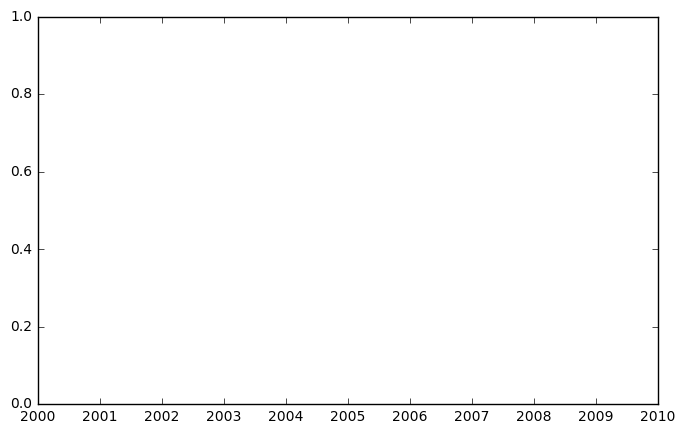

In [39]:
table = "^Channel^Acceptance^\n"

for ch in [12, 34, 86, 134, 148, 190, 213]:
    plot_channel(ch)
    indices = [dates.index(date) for date in sorted(dates)[-2:]]
    a = np.mean(ch_df.iloc[ch, indices])
    table += "|%d|%0.2f|\n" % (ch, a)

table2 = "^Channel^Acceptance^Uncertainty^\n"
for ch in [27, 73, 167, 203]:
    plot_channel(ch)
    indices = [dates.index(date) for date in sorted(dates)[-2:]]
    a = np.mean(ch_df.iloc[ch, indices])
    table2 += "|%d|%0.2f|\n" % (ch, a)

In [ ]:
print(table)

print(table2)

# Further Analysis

### Find outliers, plot the acceptance curve, acceptance histogram, and occupancy histogram

#### Change the index in run=outliers[index] in order to change which outlier gets plotted

In [ ]:
#Find outliers, plot acc of one of them

outlier_indices_low = np.array(np.where(accs < (evo_mean-1.5*evo_std))).flatten()
outlier_indices_high= np.array(np.where(accs > (evo_mean+1.5*evo_std))).flatten()

outlier_indices=outlier_indices_low.tolist() + outlier_indices_high.tolist()

outliers = bottom_runs[outlier_indices]
print("Outliers :", outliers)
run = outliers[0] #change index to change which outlier
print('Run: ',run)
runlist = file_to_list(find_file(run)[0])

bot_run=runlist[0]
tb_run=runlist[1]
tr_run=runlist[2]

x, acc, err = analyze.acceptance_curve_3runs(bot_run, tb_run, tr_run)

plt.figure(figsize=(9,6))
for ch, a in enumerate(acc):
    plt.plot(x, a, color='black', linewidth=1, alpha=0.6)
    plt.title("Acceptance curve for: %d" %run)
    
plt.xlim(-10, 200)
plt.xlabel('threshold')
plt.ylabel('spe acceptance')
plt.show()

In [ ]:
#doesn't save the data
thresholds = analyze.get_thresholds(analyze.find_regular_run(bot_run))
acc, acc_stat, acc_sys = analyze.acceptance_3runs(bot_run, tb_run, tr_run, thresholds)
occ, occ_sys, occ_stat = analyze.occupancy_3runs(bot_run, tb_run, tr_run)

on_channels = np.where(occ > 0.05)[0]

acc=acc[on_channels]
occ=occ[on_channels]

In [ ]:
#plot the occupancy of one runlist
plt.hist(occ, bins=50, range=(0,1.1))
plt.title("Occupancy for %s " %find_file(run)[0])
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.xlim(0,0.25)
plt.show()

In [ ]:
#plot the acceptance of one runlist
plt.hist(acc, bins=50, range=(0,1.1))
plt.title("Acceptance for %s " %find_file(run)[0])
plt.xlabel("SPE Acceptance")
plt.ylabel("Counts")
plt.xlim(0, 1.1)
plt.show()

In [ ]:
runlist= find_file(run)[0]

#plot acceptance of each channel
plt.figure()
plt.figure(figsize=(12,8))
plt.errorbar(on_channels, acc, yerr=[ch_lerr_df.loc[on_channels, runlist], ch_uerr_df.loc[on_channels,runlist]], marker='.', linestyle='none')
plt.ylabel('Acceptance Fraction')
plt.xlabel('Channel #')
plt.title('Acc by Ch for %s' %runlist)
plt.show()

In [ ]:
cha_dict={}

for ch, a in zip(on_channels, acc):
    cha_dict[a]=ch
    
low_acc_ch=[]
for a in acc:
    if a<0.5:
        low_acc_ch.append(cha_dict[a])
        
print('Low acc ch: ', low_acc_ch)